# **PJME Hourly**

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics  import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [97]:
url='D:\Machine Learning\Predict Future Sales\PlayGroundSeries\PJME_hourly.csv'
df=pd.read_csv(url,sep=',')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [98]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


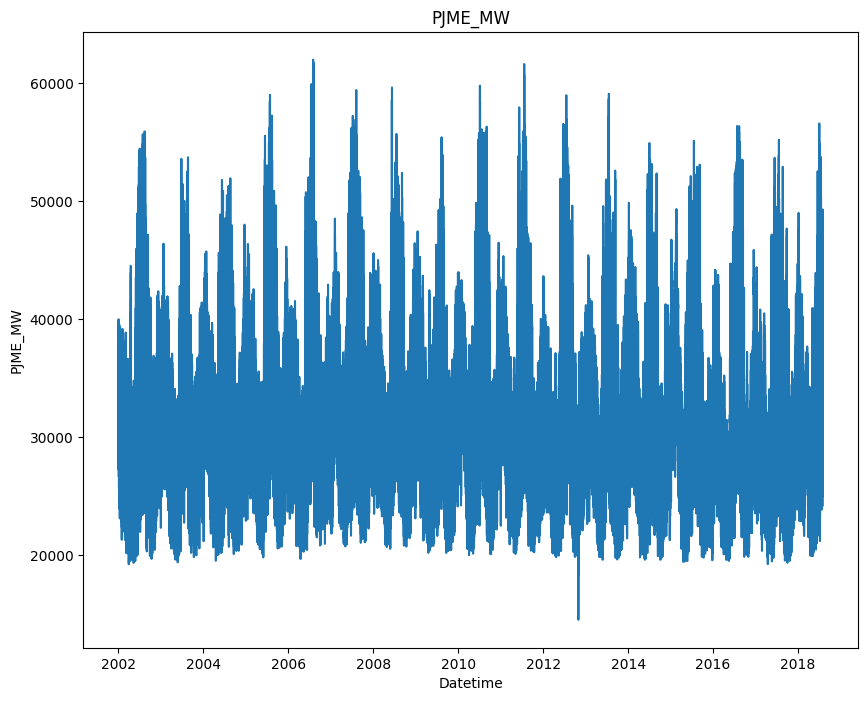

In [99]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df,x='Datetime',y='PJME_MW')
plt.title('PJME_MW')
plt.show()

In [100]:
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)
# Crear características
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.day_of_week
df['weekday'] = df['Datetime'].dt.day_name().astype(cat_type)  # Corregido aquí
df['quarter'] = df['Datetime'].dt.quarter
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['dayofyear'] = df['Datetime'].dt.day_of_year
df['dayofmonth'] = df['Datetime'].dt.day
df['weekofyear'] = df['Datetime'].dt.isocalendar().week
df['date_offset'] = (df.Datetime.dt.month * 100 + df.Datetime.dt.day - 320) % 1300
df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                      labels=['Spring', 'Summer', 'Fall', 'Winter'])

In [101]:
X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]
y=df[['PJME_MW']]
features_and_target = pd.concat([X, y], axis=1)

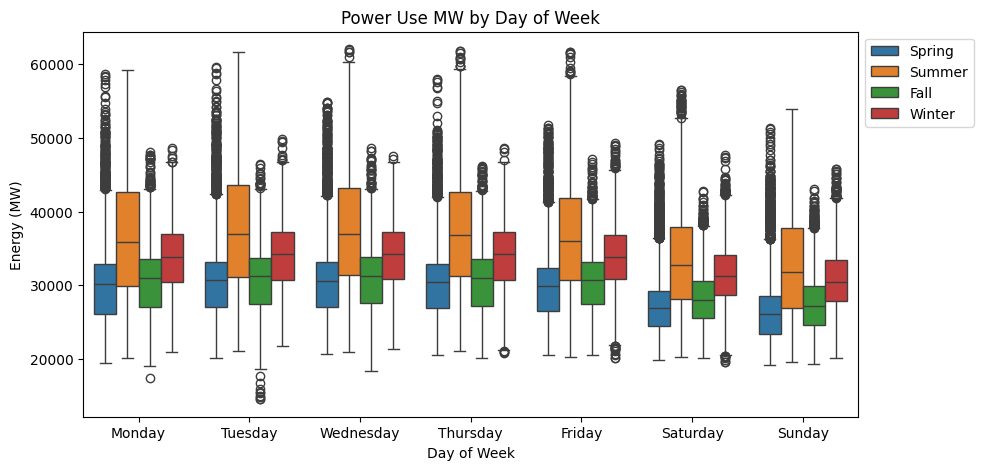

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## **Train Test Split**

In [103]:
df=df.set_index('Datetime')
df.head()

,PJME_MW,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 02:00:00,25147.0,2,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 03:00:00,24574.0,3,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 04:00:00,24393.0,4,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 05:00:00,24860.0,5,1,Tuesday,4,12,2002,365,31,1,911,Winter


In [104]:
df.head(25)

,PJME_MW,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 02:00:00,25147.0,2,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 03:00:00,24574.0,3,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 04:00:00,24393.0,4,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 05:00:00,24860.0,5,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 06:00:00,26222.0,6,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 07:00:00,28702.0,7,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 08:00:00,30698.0,8,1,Tuesday,4,12,2002,365,31,1,911,Winter
2002-12-31 09:00:00,31800.0,9,1,Tuesday,4,12,2002,365,31,1,911,Winter


## **Train Test Split**

In [105]:
split_date='2015-06-01 00:00:00'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()
print(df_train.shape)
print(df_test.shape)

(117550, 12)
(27816, 12)


In [106]:
df_train_prophet=df_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
df_train_prophet.head()

,ds,y,hour,dayofweek,weekday,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
0,2002-12-31 01:00:00,26498.0,1,1,Tuesday,4,12,2002,365,31,1,911,Winter
1,2002-12-31 02:00:00,25147.0,2,1,Tuesday,4,12,2002,365,31,1,911,Winter
2,2002-12-31 03:00:00,24574.0,3,1,Tuesday,4,12,2002,365,31,1,911,Winter
3,2002-12-31 04:00:00,24393.0,4,1,Tuesday,4,12,2002,365,31,1,911,Winter
4,2002-12-31 05:00:00,24860.0,5,1,Tuesday,4,12,2002,365,31,1,911,Winter


In [107]:
model=Prophet()
model.fit(df_train_prophet)
df_test_prophet=df_test.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
df_test_fcst=model.predict(df_test_prophet)
df_test_fcst.head()

12:10:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-01 01:00:00,32033.233212,20574.179616,29954.801794,32033.233212,32033.233212,-6668.155445,-6668.155445,-6668.155445,-4404.052682,...,-1081.562756,-1081.562756,-1081.562756,-1182.540008,-1182.540008,-1182.540008,0.0,0.0,0.0,25365.077767
1,2015-06-01 02:00:00,32033.247576,19457.405679,28635.124188,32033.247576,32033.247576,-7981.356123,-7981.356123,-7981.356123,-5888.363544,...,-919.647745,-919.647745,-919.647745,-1173.344834,-1173.344834,-1173.344834,0.0,0.0,0.0,24051.891453
2,2015-06-01 03:00:00,32033.261940,18936.242624,27850.162404,32033.261940,32033.261940,-8665.550258,-8665.550258,-8665.550258,-6742.353191,...,-759.052163,-759.052163,-759.052163,-1164.144904,-1164.144904,-1164.144904,0.0,0.0,0.0,23367.711683
3,2015-06-01 04:00:00,32033.276305,18823.158893,27520.503205,32033.276305,32033.276305,-8622.692926,-8622.692926,-8622.692926,-6867.127049,...,-600.625563,-600.625563,-600.625563,-1154.940314,-1154.940314,-1154.940314,0.0,0.0,0.0,23410.583379
4,2015-06-01 05:00:00,32033.290669,19529.031288,28646.533521,32033.290669,32033.290669,-7766.019426,-7766.019426,-7766.019426,-6175.109610,...,-445.178659,-445.178659,-445.178659,-1145.731158,-1145.731158,-1145.731158,0.0,0.0,0.0,24267.271243


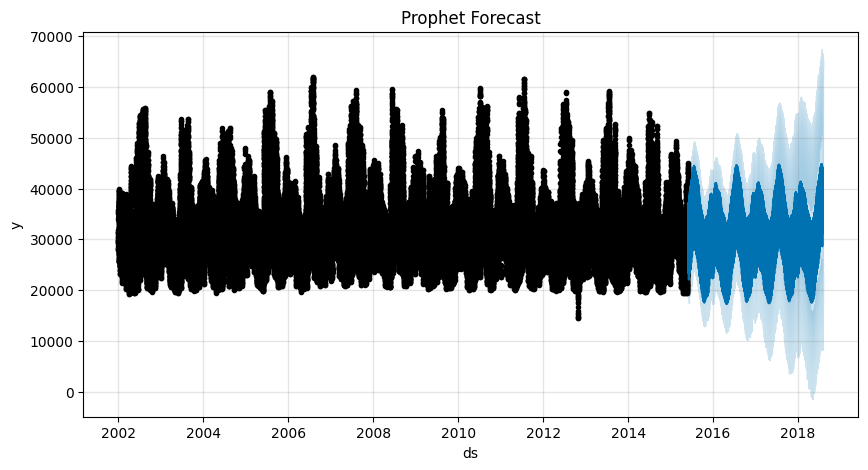

In [108]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

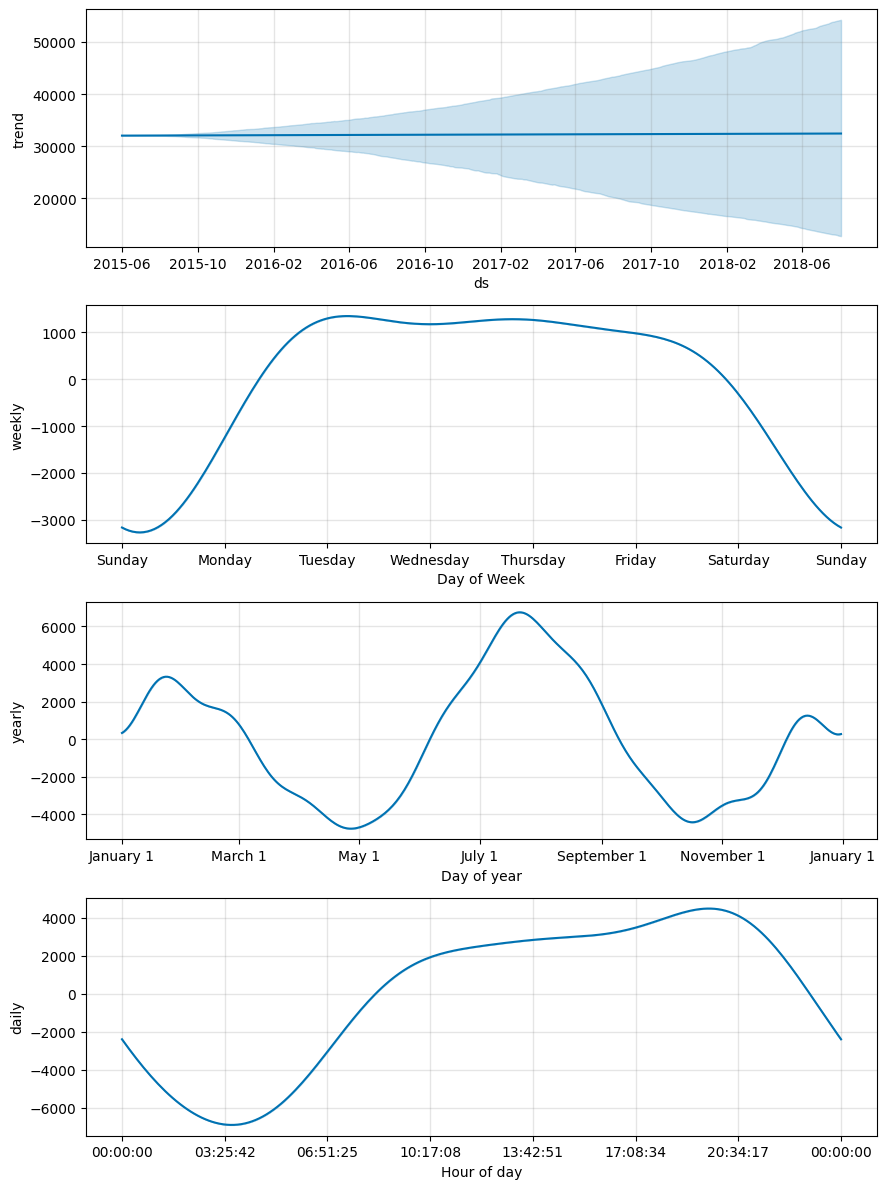

In [109]:
fig=model.plot_components(df_test_fcst)
plt.show()

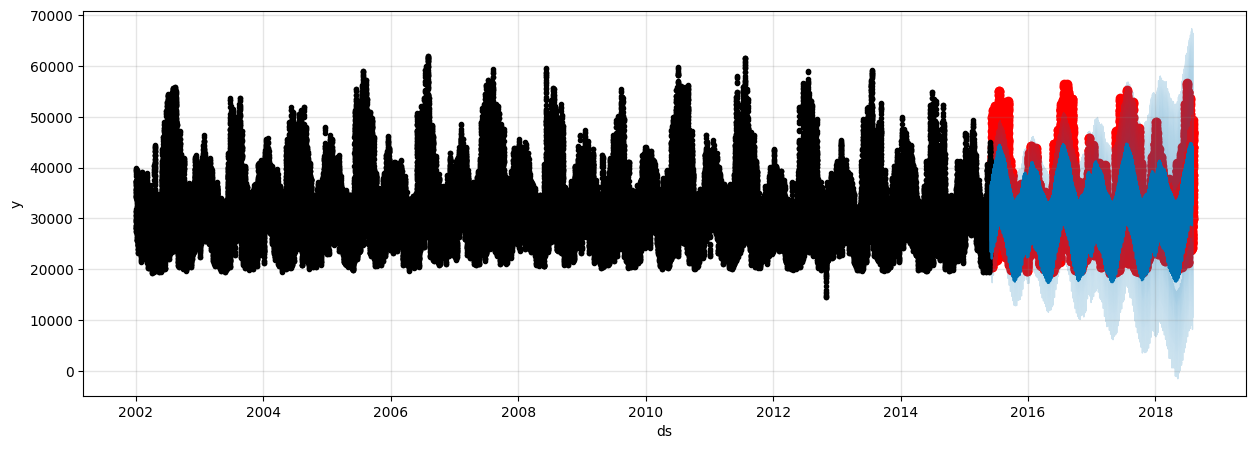

In [110]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

## **Evaluate the Model with Error of Metrics**

In [122]:
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],y_pred=df_test_fcst['yhat']))

6791.85097265008

In [123]:
mean_absolute_error(y_true=df_test['PJME_MW'],y_pred=df_test_fcst['yhat'])

5453.576397993803

In [124]:
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],y_pred=df_test_fcst['yhat'])*100

17.944074906800875

In [125]:
# Calcula el R² ajustado
r2=r2_score(y_true=df_test['PJME_MW'],y_pred=df_test_fcst['yhat'])*100
print(f'R^2 : {r2}')

R^2 : -8.84156883921159


In [127]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

13:41:37 - cmdstanpy - INFO - Chain [1] start processing
13:47:18 - cmdstanpy - INFO - Chain [1] done processing


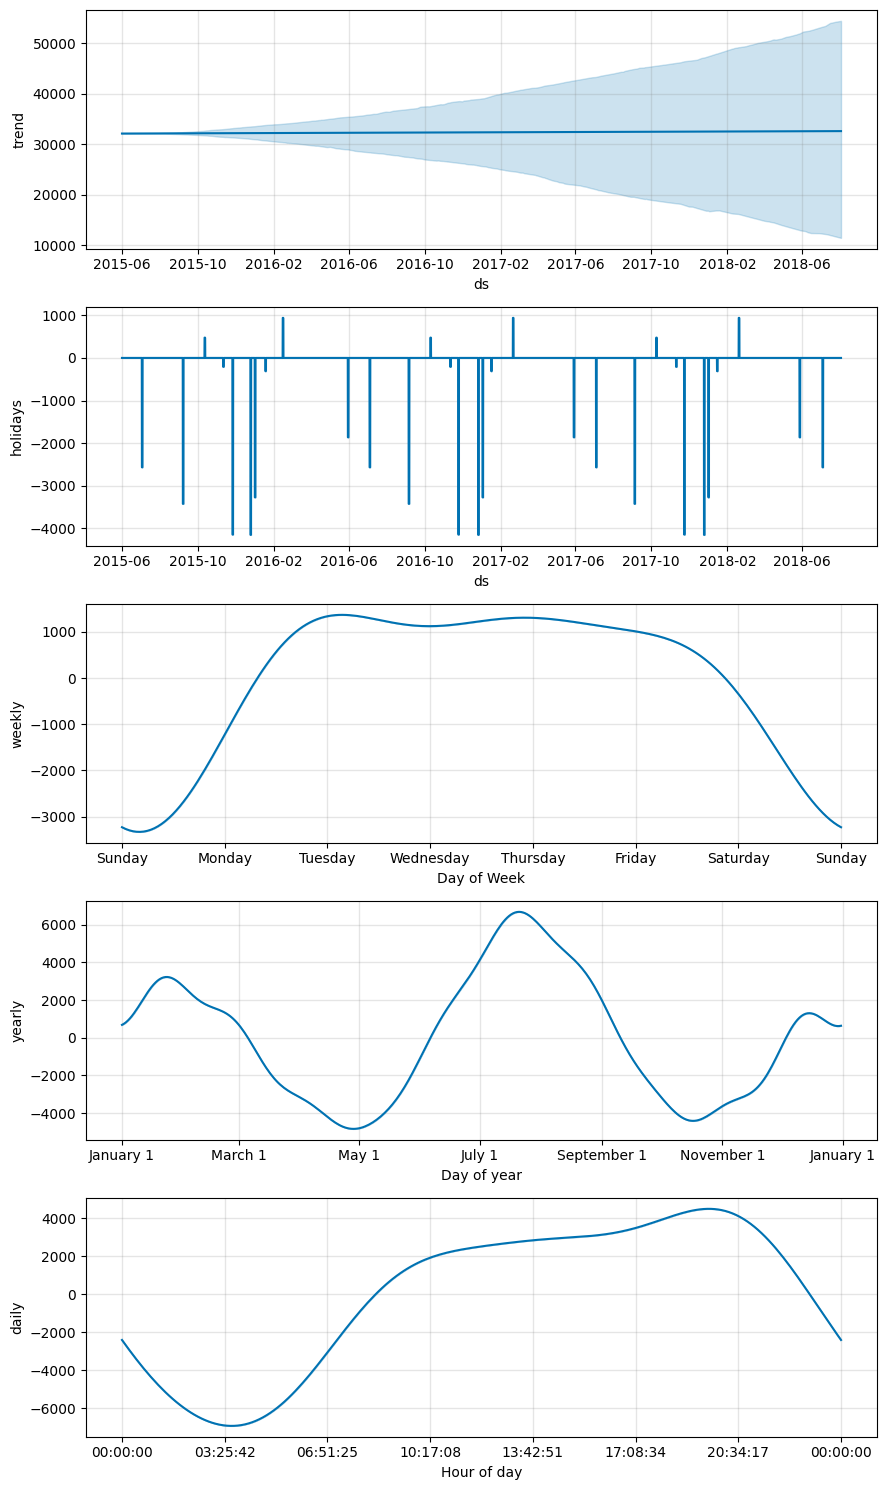

In [130]:
# Time
model_with_holidays=Prophet(holidays=holiday_df)
model_with_holidays.fit(df_train_prophet)
df_test_prophet_with_holds = model_with_holidays.predict(df_test_prophet)
fig = model_with_holidays.plot_components(df_test_prophet_with_holds)
plt.show()

In [132]:
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                   y_pred=df_test_prophet_with_holds['yhat']))

6819.081654275752

In [133]:
mean_absolute_error(y_true=df_test['PJME_MW'],y_pred=df_test_prophet_with_holds['yhat'])

5480.245758575417

In [135]:
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],y_pred=df_test_prophet_with_holds['yhat'])*100

18.05423454487274

In [137]:
# Calcula el R² ajustado
r2=r2_score(y_true=df_test['PJME_MW'],y_pred=df_test_prophet_with_holds['yhat'])*100
print(f'R^2 : {r2}')

R^2 : -9.716079068442095


## **Predict into the Future**

In [136]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-06-01 01:00:00,25494.557236
1,2015-06-01 02:00:00,24185.787811
2,2015-06-01 03:00:00,23505.891196
3,2015-06-01 04:00:00,23552.864111
4,2015-06-01 05:00:00,24413.372450


In [141]:
print(forecast['ds'].min())
print(forecast['ds'].max())

2015-06-01 01:00:00
2016-05-31 00:00:00


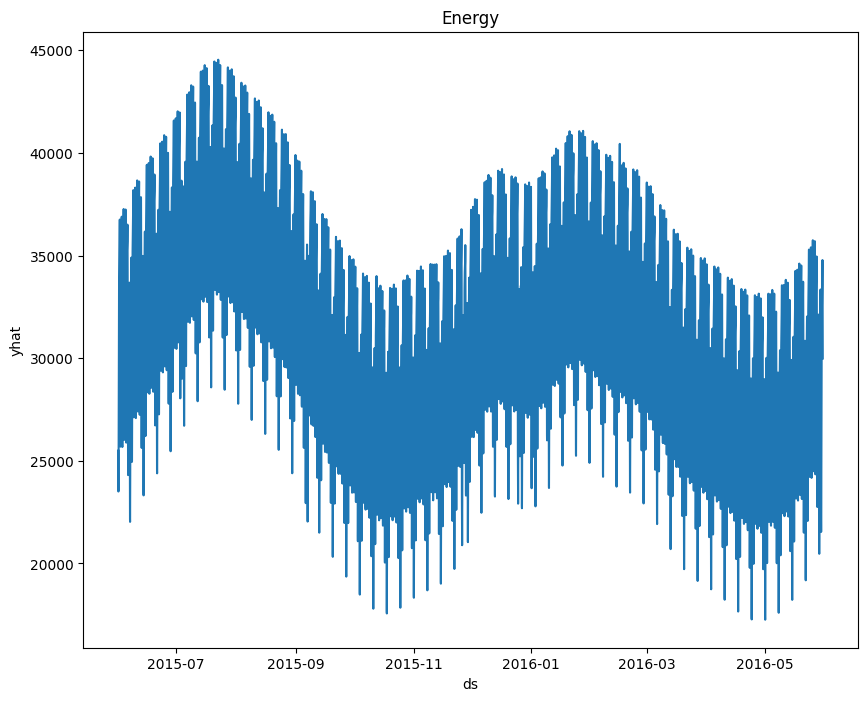

In [139]:
plt.figure(figsize=(10,8))
sns.lineplot(data=forecast,x='ds',y='yhat')
plt.title('Energy')
plt.show()